In [27]:
#!/usr/bin/env python3
import importlib
import matching
import reconstruction
import bundle_adjustment
import utilis

importlib.reload(matching)
importlib.reload(reconstruction)
importlib.reload(bundle_adjustment)
importlib.reload(utilis)

from matching import FeatureMatcher, MatchConfig
from reconstruction import Reconstruction, ReconstructionCfg
from bundle_adjustment import BundleAdjuster, BAConfig
from utilis import *

# logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("SFM")

In [ ]:
# ----------------------------------------------------------------------------
# 1) CONFIGURATION & SETUP
# ----------------------------------------------------------------------------


dataset_path = './datasets/House'
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
ext = rename_images_sequentially(dataset_path, valid_extensions=valid_extensions)


# After renaming, use this pattern to load them
img_pattern = f"{{idx:02d}}{ext}"
print(f"Image pattern: {img_pattern}")

output_dir = Path('./outputs')
output_dir.mkdir(exist_ok=True)

reprojection_errors = []
points_history = []

# Get list of image filenames after renaming
image_files = get_image_files(dataset_path, ext=ext)
n_imgs = len(image_files)
logger.info(f"Found {n_imgs} images in {dataset_path}")

# Load camera calibration matrix K
calib_path = Path(dataset_path) / 'K.txt'
K = load_calibration_matrix(calib_path)
logger.info(f"Loaded calibration matrix K:\n{K}")

# Load images
images = []
for idx in range(n_imgs):
    img_path = Path(dataset_path) / img_pattern.format(idx=idx)
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"Failed to load image {img_path}")
    images.append(img)
logger.info(f"Loaded {len(images)} images.")


INFO:SFM:Found 300 images in ./datasets/Bblock1
INFO:SFM:Loaded calibration matrix K:
[[1.40630435e+03 0.00000000e+00 7.21827946e+02]
 [0.00000000e+00 1.40340401e+03 4.57655556e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


✅ Done renaming images.
Image pattern: {idx:02d}.jpg


INFO:SFM:Loaded 300 images.


INFO:SFM:Running feature matching pipeline…
INFO:matching:Extracting features...
INFO:matching:Extracted features from 300 images.


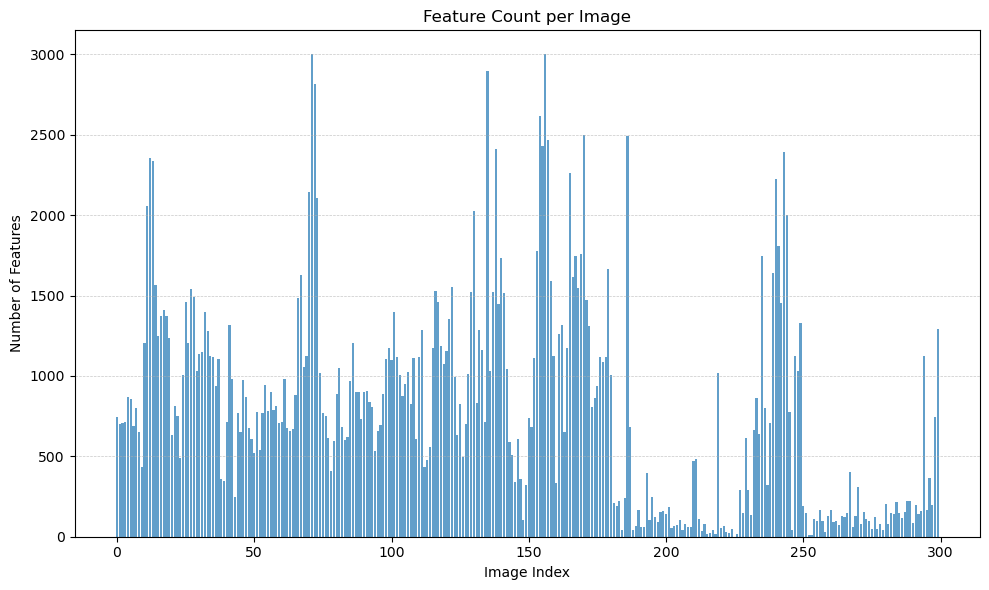

INFO:matching:Matching feature pairs...


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# ----------------------------------------------------------------------------
# 2) FEATURE MATCHING
# ----------------------------------------------------------------------------
fm_cfg = MatchConfig(
    dataset_path=dataset_path,
    img_pattern=img_pattern,
    ratio_thresh=0.75,
    ransac_thresh=3.0,
    min_inliers=20,
    use_flann=False,
    nfeatures=0  # Deafult = 0
)

logger.info("Running feature matching pipeline…")
fm = FeatureMatcher(n_imgs=n_imgs, cfg=fm_cfg)
fm.images = images  # Optionally skip reloading images
fm.extract_features()
fm.plot_feature_histogram()
fm.match_pairs()
fm.filter_geometric()
fm.plot_best_match()

# fm.run() # Or call fm.run() to do full pipeline including loading

keypoints = fm.kps
matches = fm.matches
adjacency = fm.adjacency


logger.info("✅ Feature matching complete.")

In [ ]:
# ----------------------------------------------------------------------------
# 3) INCREMENTAL RECONSTRUCTION
# ----------------------------------------------------------------------------

import os
cpu_cores = os.cpu_count()
print(f"Detected {cpu_cores} CPU cores")

recon_cfg = ReconstructionCfg(
    K=K,
    min_inliers_baseline=50,
    essential_ransac_thresh=3.0,
    pnp_reproj_thresh=4.0,
    pnp_iterations=500,
    pnp_method= cv2.SOLVEPNP_ITERATIVE, #
    min_pnp_correspondences=10,
    max_failed_attempts=3,
    bundle_every=5,
    verbose=True,
    num_threads = cpu_cores #-> USE min(cpu_cores, 4)
)

recon = Reconstruction(
    keypoints=keypoints,
    matches=matches,
    img_adjacency=adjacency,
    cfg=recon_cfg,
    images=images
)

logger.info("Selecting baseline…")
baseline = recon.select_baseline(top_percent=0.25)
logger.info(f"Baseline selected: {baseline}")

try:
    recon.initialize(baseline)
except Exception as e:
    logger.error(f"Initialization failed: {e}")
    raise

pts3d_initial = [p.coords for p in recon.points3d]
logger.info(f"Starting Points: {len(pts3d_initial)}, Starting Cameras: {len(recon.poses)}")

points_history.append(len(recon.points3d))


INFO:SFM:Selecting baseline…
INFO:reconstruction:Baseline pair: (40, 41) with 711 matches, 180795 inliers
INFO:SFM:Baseline selected: (40, 41)
INFO:reconstruction:Triangulating 709 points between images 40 and 41
INFO:reconstruction:Successfully added 709 new colored 3D points between images 40 and 41
INFO:reconstruction:Initialized reconstruction with baseline image pair.
INFO:SFM:Starting Points: 709, Starting Cameras: 2


Detected 32 CPU cores


In [ ]:
# ----------------------------------------------------------------------------
# 4) SET UP BUNDLE ADJUSTMENT
# ----------------------------------------------------------------------------

def run_ba():
    logger.info("Starting bundle adjustment…")
    cam_ids = list(recon.poses.keys())
    n_cams = len(cam_ids)

    init_rvecs = {}
    init_tvecs = {}
    for norm_i, cam in enumerate(cam_ids):
        R, t = recon.poses[cam]
        rvec, _ = cv2.Rodrigues(R)
        init_rvecs[norm_i] = rvec.ravel()
        init_tvecs[norm_i] = t.ravel().reshape(3, 1)

    pts3d_list = [p.coords for p in recon.points3d]
    n_pts = len(pts3d_list)

    cam_idx, pt_idx, pts2d = [], [], []
    for pi, p3d in enumerate(recon.points3d):
        for cam, kpt_i in p3d.observations.items():
            cam_norm = cam_ids.index(cam)
            cam_idx.append(cam_norm)
            pt_idx.append(pi)
            pts2d.append(keypoints[cam][kpt_i].pt)

    cam_idx = np.array(cam_idx)
    pt_idx = np.array(pt_idx)
    pts2d = np.array(pts2d, dtype=np.float64)

    ba_cfg = BAConfig(
        max_nfev=1500,
        ftol=1e-6,
        xtol=1e-6,
        gtol=1e-6,
        loss='huber', #Can use Cauchy, L1, Huber and more
        f_scale=1.0,
        method='trf'
    )

    ba = BundleAdjuster(K, cam_idx, pt_idx, pts2d, n_cams, n_pts,
                        init_rvecs, init_tvecs, pts3d_list, ba_cfg)

    rvecs_opt, tvecs_opt, pts3d_opt = ba.optimize()

    for norm_i, cam in enumerate(cam_ids):
        rvec = rvecs_opt[norm_i]
        tvec = tvecs_opt[norm_i]
        Ropt, _ = cv2.Rodrigues(rvec)
        recon.poses[cam] = (Ropt, tvec)

    for i, xyz in enumerate(pts3d_opt):
        recon.points3d[i].coords = xyz

    params_opt = pack_params(rvecs_opt, tvecs_opt, pts3d_opt)
    avg_error = ba.compute_average_reprojection_error(params_opt)

    reprojection_errors.append(avg_error)
    points_history.append(len(recon.points3d))


logger.info("Bundle adjustment has been set up")

INFO:SFM:Bundle adjustment has been set up


In [ ]:
# ----------------------------------------------------------------------------
# 5) GROW RECONSTRUCTION WITH BUNDLE ADJUSTMENT
# ----------------------------------------------------------------------------
from tqdm.notebook import tqdm  # Better support for VSCode/Jupyter
logger.info("Growing reconstruction with live progress…")

max_attempts = 3
pbar = tqdm(total=n_imgs, desc="Images registered", dynamic_ncols=True)
pbar.update(len(recon.poses))  # Initial baseline count

last_pose_count = len(recon.poses)


while len(recon.poses) < n_imgs:
    success = False
    for attempt in range(max_attempts):
        try:
            recon.grow(bundle_adjust_fn=run_ba, pbar=pbar)
            success = True
            break
        except Exception as e:
            logger.warning(f"Reconstruction growth failed: {str(e)}. Retrying...")

    if not success:
        logger.error("Stopping growth. Failed after maximum retries.")
        break

    # If no progress was made since last iteration, stop
    if len(recon.poses) == last_pose_count:
        logger.warning("No new poses were added in this iteration. Stopping to prevent infinite loop.")
        break

    last_pose_count = len(recon.poses)

pbar.close()

INFO:SFM:Growing reconstruction with live progress…


Images registered:   0%|          | 0/43 [00:00<?, ?it/s]

INFO:reconstruction:Added image 39 with 498 PnP inliers
INFO:reconstruction:Added 382 new colored 3D points during addition of image 39
INFO:reconstruction:Added image 38 with 241 PnP inliers
INFO:reconstruction:Added 157 new colored 3D points during addition of image 38
INFO:reconstruction:Added image 42 with 174 PnP inliers
INFO:reconstruction:Added 190 new colored 3D points during addition of image 42
INFO:reconstruction:Added image 37 with 129 PnP inliers
INFO:reconstruction:Added 107 new colored 3D points during addition of image 37
INFO:reconstruction:Added image 18 with 53 PnP inliers
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2547e+04                                    4.14e+05    
       1              2         1.2490e+04      5.68e+01       1.27e-04       4.41e+05    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.2547e+04, final cost 1.2490e+04, first-order optimality 4.41e+05.


INFO:reconstruction:Added image 20 with 53 PnP inliers
ERROR:reconstruction:Failed to add image 35: PnP failed or insufficient inliers
ERROR:reconstruction:Failed to add image 35: PnP failed or insufficient inliers


In [ ]:
# ----------------------------------------------------------------------------
# 6) FINAL BUNDLE ADJUSTMENT AND VISUALIZATION
# ----------------------------------------------------------------------------
logger.info("Running final bundle adjustment…")
run_ba()
visualize_current_state(recon, "Final Reconstruction")

INFO:SFM:Running final bundle adjustment…
INFO:SFM:Starting bundle adjustment…
INFO:utilis:Final Reconstruction | Points: 1545, Cameras: 8


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2490e+04                                    4.41e+05    
       1              2         1.2457e+04      3.38e+01       9.03e-05       3.79e+05    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.2490e+04, final cost 1.2457e+04, first-order optimality 3.79e+05.


In [ ]:
# ----------------------------------------------------------------------------
# 7) SUMMARY LOGGING
# ----------------------------------------------------------------------------
used_images = sorted(recon.poses.keys())
total_3d_points = len(recon.points3d)
avg_error = np.mean(reprojection_errors) if reprojection_errors else -1
avg_points_per_image = total_3d_points / len(used_images) if used_images else 0

logger.info("=" * 60)
logger.info(" Structure from Motion Summary")
logger.info("=" * 60)
logger.info(f" Images used             : {len(used_images)} / {n_imgs}")
logger.info(f" Final 3D points         : {total_3d_points}")
logger.info(f" Avg reprojection error : {avg_error:.2f} pixels")
logger.info(f" Avg 3D pts per image   : {avg_points_per_image:.2f}")
logger.info("=" * 60)


INFO:SFM:============================================================
INFO:SFM: Structure from Motion Summary
INFO:SFM:============================================================
INFO:SFM: Images used             : 68 / 68
INFO:SFM: Final 3D points         : 53562
INFO:SFM: Avg reprojection error : 0.87 pixels
INFO:SFM: Avg 3D pts per image   : 787.68
INFO:SFM:============================================================


In [ ]:
# ----------------------------------------------------------------------------
# 8) SAVE FINAL 3D RECONSTRUCTION
# ----------------------------------------------------------------------------
ply_path = output_dir / "reconstruction_condorcet.ply"
# ply_path = output_dir / "house.ply"
save_reconstruction_ply(recon.points3d, ply_path, camera_poses=recon.poses)

INFO:utilis:📁 Saved filtered reconstruction to: outputs/reconstruction_House_cams.ply


In [ ]:
# ----------------------------------------------------------------------------
# 9) VISUALIZE TEMPLE RING RECONSTRUCTION IN OPEN3D
# ----------------------------------------------------------------------------
display_saved_reconstruction(str(ply_path))


In [ ]:
# # ----------------------------------------------------------------------------
# # 10) VISUALIZE HOUSE RECONSTRUCTION IN OPEN3D
# # ----------------------------------------------------------------------------
# ply_path = output_dir / "reconstruction_House_cams.ply"
# display_saved_reconstruction(str(ply_path))